In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!wget http://www.pnwx.com/Accessories/Phantoms/Test/LinePair/1-010_1.jpg -O _data/sample_image.jpg

--2021-05-07 11:46:56--  http://www.pnwx.com/Accessories/Phantoms/Test/LinePair/1-010_1.jpg
Resolving www.pnwx.com (www.pnwx.com)... 50.43.65.85
Connecting to www.pnwx.com (www.pnwx.com)|50.43.65.85|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35517 (35K) [image/jpeg]
Saving to: ‘_data/sample_image.jpg’

_data/sample_image. 100%[===================>]  34.68K  78.5KB/s    in 0.4s    

2021-05-07 11:46:57 (78.5 KB/s) - ‘_data/sample_image.jpg’ saved [35517/35517]



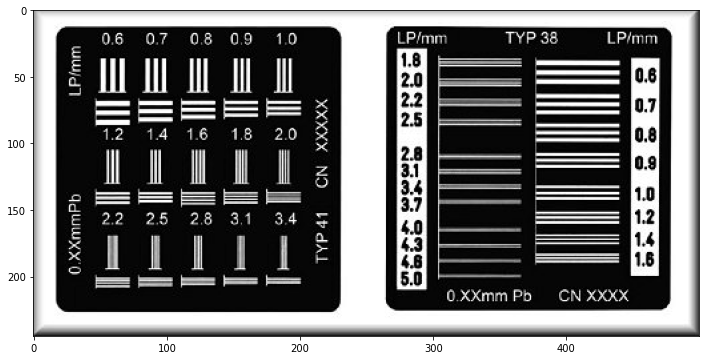

In [4]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from jax import numpy as jnp

img = Image.open("./_data/sample_image.jpg")
img = np.array(img)[:,:,0].astype(np.float32)
img = img[:img.shape[1],:]/255. - 0.5

plt.figure(figsize=(12,6))
plt.imshow(img, cmap="gray")
plt.show()

In [5]:
from jwave import geometry

In [6]:
# Create grid object
N = img.shape
dx = tuple([1 for _ in N])
grid = geometry.kGrid.make_grid(N,dx)

In [7]:
print(grid)

kGrid Object:
------------
N: (245, 500)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (245,)', '(s) (500,)']
k_vec: [['(s) (245,)', '(s) (500,)'], 'None', 'None']
k_with_kspaceop: None



In [8]:
from jwave.spectral import derivative_init

In [9]:
Dx, grid = derivative_init(img, grid, axis=0)

In [10]:
print(grid)

kGrid Object:
------------
N: (245, 500)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (245,)', '(s) (500,)']
k_vec: [['(s) (245,)', '(s) (500,)'], 'None', 'None']
k_with_kspaceop: None



In [11]:
Dx_img = Dx(img, grid, degree=1.)

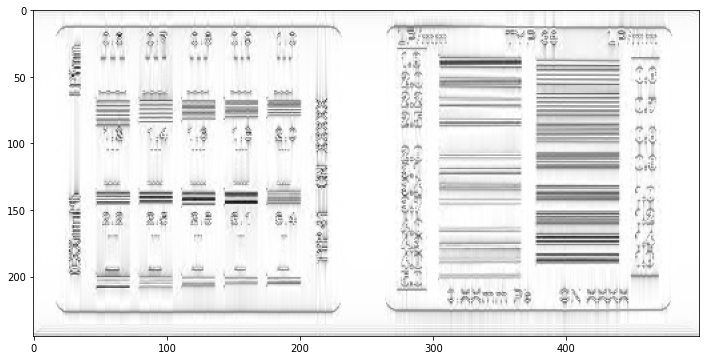

In [13]:
plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(Dx_img), cmap="binary")

In [14]:
Dy, grid = derivative_init(img, grid, axis=1)

In [15]:
Dy_img = Dy(img, grid, 1.)

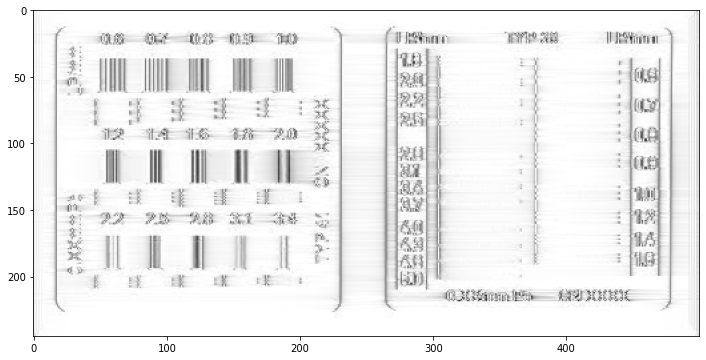

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(Dy_img), cmap="binary")

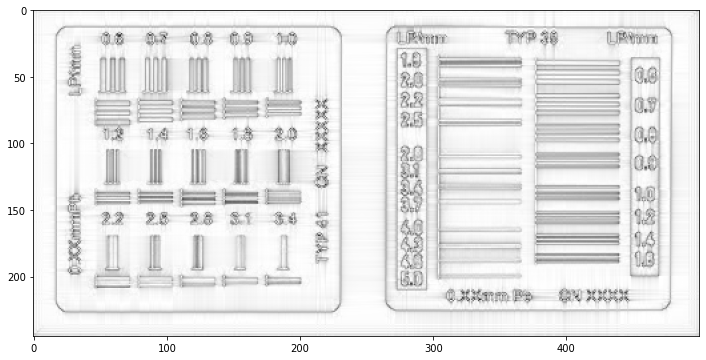

In [17]:
edges = jnp.abs(Dx_img) + jnp.abs(Dy_img)
plt.figure(figsize=(12,6))
plt.imshow(edges, cmap="binary")

In [18]:
%%timeit 
Dx_img = Dx(img, grid, 1.)

3.99 ms ± 93.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
import jax
Dx_fast = jax.jit(lambda x,y: Dx(x,y,1.))

In [20]:
%%timeit 
Dx_fast(img, grid).block_until_ready()

203 µs ± 6.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%%timeit 
Dy_img = Dy(img, grid, 1.)

3.73 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
import jax
Dy_fast = jax.jit(lambda x,y: Dy(x,y,1.))

In [23]:
%%timeit 
Dy_fast(img, grid).block_until_ready()

181 µs ± 3.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
from jwave.geometry import Staggered
Dx, grid = derivative_init(img, grid, axis=0, staggered=Staggered.FORWARD)

In [25]:
print(grid)

kGrid Object:
------------
N: (245, 500)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (245,)', '(s) (500,)']
k_vec: [['(s) (245,)', '(s) (500,)'], ['(s) (245,)', '(s) (500,)'], ['(s) (245,)', '(s) (500,)']]
k_with_kspaceop: None



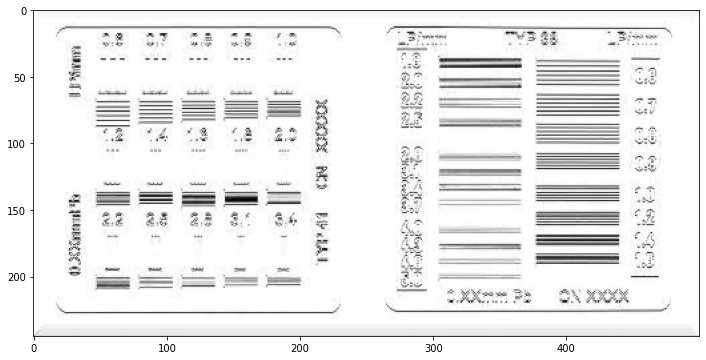

In [26]:
Dx_img = Dx(img, grid, 1.)
plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(Dx_img), cmap="binary")

In [27]:
grid = grid.apply_kspace_operator(c_ref=1., dt=0.1)

In [28]:
print(grid)

kGrid Object:
------------
N: (245, 500)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (245,)', '(s) (500,)']
k_vec: [['(s) (245,)', '(s) (500,)'], ['(s) (245,)', '(s) (500,)'], ['(s) (245,)', '(s) (500,)']]
k_with_kspaceop: ['(s) (2, 245, 500)', '(s) (2, 245, 500)', '(s) (2, 245, 500)']



In [29]:
Dx_ksp, grid = derivative_init(img, grid, axis=0, staggered=Staggered.FORWARD, kspace_op=True)

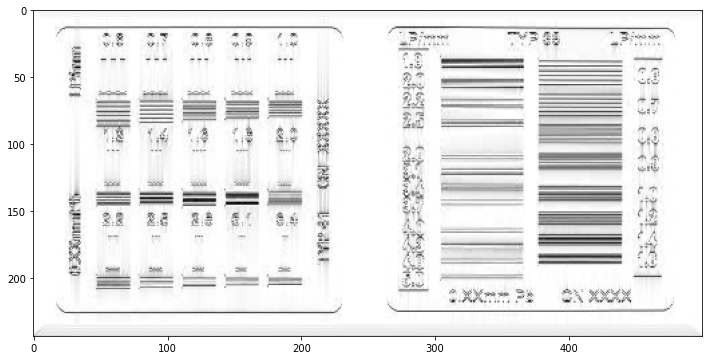

In [30]:
Dx_img = Dx_ksp(img, grid)
plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(Dx_img), cmap="binary")

In [31]:
# Multiple degrees of derivatives with vmap (saves FFTs)
D_two_orders = jax.jit(jax.vmap(Dx, in_axes=(None, None, 0)))

In [32]:
D_maps = D_two_orders(img, grid, jnp.array([1.0, 2.0]))

Text(0.5, 1.0, 'First order')

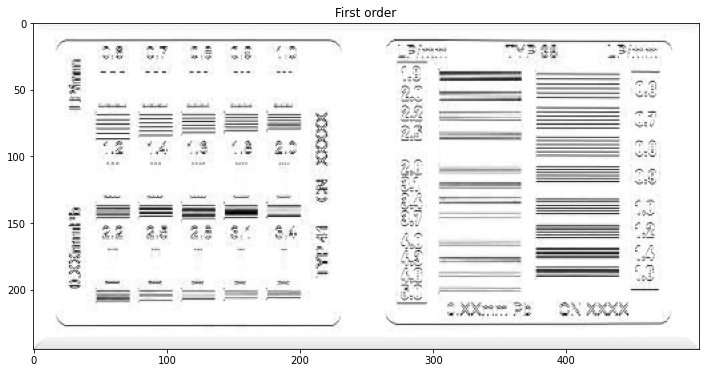

In [37]:
plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(D_maps[0]), cmap="binary")
plt.title("First order")

Text(0.5, 1.0, 'Second order')

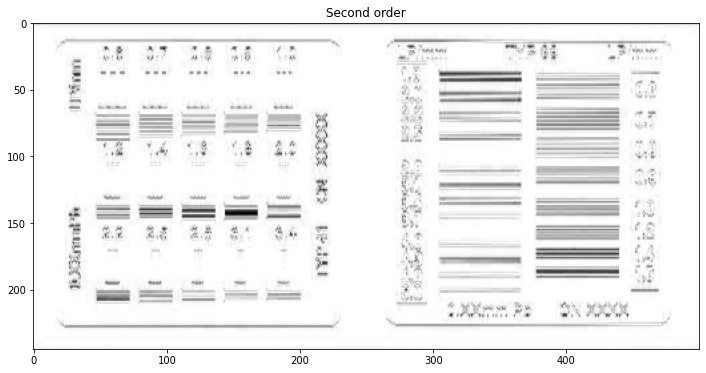

In [38]:
plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(D_maps[1]), cmap="binary")
plt.title("Second order")